<a href="https://colab.research.google.com/github/Abdel-rahim/preceptron_test/blob/main/What_does_a_CNN_see%3F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook aims at **Model Interpretability** using **TF2.0**. Machine learning models, especially Deep Learning models are often considered as a black box and hard to interpret. Well, this statement is neither completely true nor it is completely false. It is a fact that debugging a deep learning model is way harder than other machine learning models but there are ways by which you can get insights about your model and to an extent, you can see what is happening.

In [ ]:
!pip install tensorflow-gpu

     |████████████████████████████████| 380.8MB 68kB/s 
     |████████████████████████████████| 3.8MB 39.5MB/s 
     |████████████████████████████████| 450kB 26.8MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=da9a03be853d3d134069010e91c2fe8588d380ef7d7bd612c480b0dfbbdb53a5
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 1.14.0 has requirement tensorboard<1.15.0,>=1.14.0, but you'll have tensorboard 2.0.0 which is incompatible.
ERROR: tensorflow 1.14.0 has requirement tensorflow-estimator<1.15.0rc0,>=1.14.0rc0, but you'll have tensorflow-estimator 2.0.0 which is incompatible.
  Found existing installation: tensorboard 1.14.0
    Uninstalling tensorboard-1.14.0:
      Successfully uninstalled tensorboard-1.14.0
  Found existing installation: tensorflow-estimator 1.14.0
    Uninstalling tensorflow-estimator-1.14.0:
      Successfully uninstalled tens

We will be using [Kaggle](https://www.kaggle.com) dataset to do our experiment. If you want to run this notebook on your side, you need to download your **`kaggle.json`** file from your Kaggle account and then upload it here so that you can download the dataset.

In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

We have uploaded the json file. Now we are ready to download the dataset. We will be using the [10 Monkey Species](https://www.kaggle.com/slothkong/10-monkey-species) dataset for this experiment. Let's download and unzip our dataset

In [ ]:
!kaggle datasets download -d slothkong/10-monkey-species
!unzip -qq 10-monkey-species.zip

 98% 537M/547M [00:13<00:00, 44.7MB/s]
100% 547M/547M [00:13<00:00, 42.8MB/s]


## Import the required libraries

In [ ]:
import warnings 
warnings.filterwarnings("ignore")

In [ ]:
import os
import glob
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.io import imread, imsave
from skimage.transform import resize 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras import layers as L
from tensorflow.keras.applications import vgg16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow as tf
import tensorflow.keras.backend as K

import imgaug as ia
from imgaug import augmenters as iaa

In [ ]:
%config InlineBackend.figure_format="svg"
%matplotlib inline


# Reproducibility is importatnt. Always set the seed!
seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)
ia.seed(seed)

In [ ]:
# Paths where the data is stored
training_data = Path('training/training/') 
validation_data = Path('validation/validation/') 
labels_path = Path('monkey_labels.txt')

We will read the `monkey_labels.txt` file to extract the information about the labels. We will store this information in a `pandas Dataframe` which makes everyone's life easier.

In [ ]:
labels_info = []

# Read the file
lines = labels_path.read_text().strip().splitlines()[1:]
for line in lines:
    line = line.split(',')
    line = [x.strip(' \n\t\r') for x in line]
    line[3], line[4] = int(line[3]), int(line[4])
    line = tuple(line)
    labels_info.append(line)
    
# Convert the data into a pandas dataframe
labels_info = pd.DataFrame(labels_info, columns=['Label', 
                                                 'Latin Name', 
                                                 'Common Name', 
                                                 'Train Images', 
                                                 'Validation Images'], 
                                                 index=None)
# Sneak peek 
labels_info.head(10)

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


The labels are `n0, n1, n2, ....` We will create a mapping of these labels where each class will be represented by an integer starting from `0` to `10`(number of classes). We will also create a mapping for the names corresponding to a class. We will be using `Common Name` for the last part

In [ ]:
# Create a dictionary to map the labels to integers
labels_dict= {'n0':0, 
              'n1':1, 
              'n2':2, 
              'n3':3, 
              'n4':4, 
              'n5':5, 
              'n6':6, 
              'n7':7, 
              'n8':8, 
              'n9':9}

# map labels to common names
names_dict = dict(zip(labels_dict.values(), 
                      labels_info["Common Name"]))
# check the mapping
print(names_dict)

{0: 'mantled_howler', 1: 'patas_monkey', 2: 'bald_uakari', 3: 'japanese_macaque', 4: 'pygmy_marmoset', 5: 'white_headed_capuchin', 6: 'silvery_marmoset', 7: 'common_squirrel_monkey', 8: 'black_headed_night_monkey', 9: 'nilgiri_langur'}


## Prepare the dataset for training and validation

In [ ]:
# Creating a dataframe for the training dataset
train_df = []
for folder in os.listdir(training_data):
    # Define the path to the images
    imgs_path = training_data / folder
    
    # Get the list of all the images stored in that directory
    imgs = sorted(imgs_path.glob('*.jpg'))
    
    # Store each image path and corresponding label 
    for img_name in imgs:
        train_df.append((str(img_name), labels_dict[folder]))


train_df = pd.DataFrame(train_df, columns=['image', 'label'], index=None)
# shuffle the dataset 
train_df = train_df.sample(frac=1.).reset_index(drop=True)

###############################################################################

# Creating dataframe for validation data in a similar fashion
valid_df = []
for folder in os.listdir(validation_data):
    imgs_path = validation_data / folder
    imgs = sorted(imgs_path.glob('*.jpg'))
    for img_name in imgs:
        valid_df.append((str(img_name), labels_dict[folder]))

        
valid_df = pd.DataFrame(valid_df, columns=['image', 'label'], index=None)
# shuffle the dataset 
valid_df = valid_df.sample(frac=1.).reset_index(drop=True)

##############################################################################

# How many samples do we have in our training and validation data?
print("Number of traininng samples: ", len(train_df))
print("\n",train_df.head(), "\n")

# sneak peek of the training and validation dataframes
print("=================================================================\n")
print("Number of validation samples: ", len(valid_df))
print("\n", valid_df.head())

Number of traininng samples:  1096

                             image  label
0  training/training/n6/n6152.jpg      6
1  training/training/n7/n7136.jpg      7
2  training/training/n3/n3157.jpg      3
3  training/training/n0/n0043.jpg      0
4  training/training/n6/n6057.jpg      6 


Number of validation samples:  272

                                 image  label
0   validation/validation/n3/n318.jpg      3
1  validation/validation/n7/n7010.jpg      7
2   validation/validation/n4/n411.jpg      4
3  validation/validation/n4/n4013.jpg      4
4  validation/validation/n9/n9015.jpg      9


### Some pseudo constants

In [ ]:
# dimensions to consider for the images
img_rows, img_cols, img_channels = 224,224,3

# batch size for training  
batch_size=16

# total number of classes in the dataset
nb_classes=10

## Data Augmentation
When you have limited data, deep models don't do very well. Deep learning models are data hungry. The more data you provide to a deep learning model, the more it performance improves (until unless your algorithm has reached a limit). This is where data augmentation really comes handy. We will be using **[imgaug](https://github.com/aleju/imgaug)**, a very powerful library for augmenting our images. We will define a sequence of augmentations and for each image, one of these augmentations will be applied to the image during training


In [ ]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

### Data Generators

In [ ]:
def data_generator(data, 
                   batch_size,
                   preprocessing_fn = None,
                   is_validation_data=False):
    # Get total number of samples in the data
    n = len(data)
    nb_batches = int(np.ceil(n/batch_size))

    # Get a numpy array of all the indices of the input data
    indices = np.arange(n)
    
    while True:
        if not is_validation_data:
            # shuffle indices for the training data
            np.random.shuffle(indices)
            
        for i in range(nb_batches):
            # get the next batch 
            next_batch_indices = indices[i*batch_size:(i+1)*batch_size]
            nb_examples = len(next_batch_indices)
            
            # Define two numpy arrays for containing batch data and labels
            batch_data = np.zeros((nb_examples, 
                           img_rows, 
                           img_cols, 
                           img_channels), 
                          dtype=np.float32)
            batch_labels = np.zeros((nb_examples, nb_classes), dtype=np.float32)
            
            # process the next batch
            for j, idx in enumerate(next_batch_indices):
                img = cv2.imread(data.iloc[idx]["image"])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = data.iloc[idx]["label"]
                
                if not is_validation_data:
                    img = seq.augment_image(img)
                
                img = cv2.resize(img, (img_rows, img_cols)).astype(np.float32)
                batch_data[j] = img
                batch_labels[j] = to_categorical(label,num_classes=nb_classes)
            
            if preprocessing_fn is not None:
                batch_data = preprocessing_fn(batch_data)
            
            yield batch_data, batch_labels

In [ ]:
# We will be using vgg16 as our base network. So we have to apply the same
# preprocessing as used in the original model
preprocessing_fn = vgg16.preprocess_input

#training data generator 
train_data_gen = data_generator(train_df, 
                                batch_size, 
                                preprocessing_fn)

# validation data generator 
valid_data_gen = data_generator(valid_df, 
                                batch_size,
                                preprocessing_fn,
                                is_validation_data=True)

## Modelling
We will be doing transfer learning here and I am choosing vgg16 as the base network. You can choose whichever network you want. Also, as the dataset is very small and very very similar to Imagenet, we would make minimal changes in the network to keep the trainable parameters as few as possible

In [ ]:
def get_base_model():
    base_model = vgg16.VGG16(input_shape=(img_rows, img_cols, img_channels), 
                       weights='imagenet', 
                       include_top=True)
    return base_model

# get the base model
base_model = get_base_model()

#  get the output of the second last dense layer 
base_model_output = base_model.layers[-2].output

# add new layers 
x = L.Dropout(0.5,name='drop2')(base_model_output)
output = L.Dense(nb_classes, activation='softmax', name='fc3')(x)

# define a new model 
model = Model(base_model.input, output)

# Freeze all the base model layers 
for layer in base_model.layers[:-1]:
    layer.trainable=False

# compile the model and check it 
optimizer = RMSprop(0.001)
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Use earlystopping 
es = EarlyStopping(patience=3, restore_best_weights=True)

# checkpoint to save model
chkpt = ModelCheckpoint(filepath="monkey_model.h5", save_best_only=True)

# number of training and validation steps for training and validation
nb_train_steps = int(np.ceil(len(train_df)/batch_size))
nb_valid_steps = int(np.ceil(len(valid_df)/batch_size))

# number of epochs 
nb_epochs=10

In [ ]:
# train the model 
history1 = model.fit_generator(train_data_gen, 
                              epochs=nb_epochs, 
                              steps_per_epoch=nb_train_steps, 
                              validation_data=valid_data_gen, 
                              validation_steps=nb_valid_steps,
                              callbacks=[es,chkpt])

Epoch 1/10
69/69 [==============================] - 64s 929ms/step - loss: 0.7832 - accuracy: 0.8038 - val_loss: 0.1269 - val_accuracy: 0.9522
Epoch 2/10
69/69 [==============================] - 60s 863ms/step - loss: 0.1740 - accuracy: 0.9480 - val_loss: 0.0356 - val_accuracy: 0.9816
Epoch 3/10
69/69 [==============================] - 59s 857ms/step - loss: 0.0927 - accuracy: 0.9690 - val_loss: 0.0315 - val_accuracy: 0.9890
Epoch 4/10
69/69 [==============================] - 60s 867ms/step - loss: 0.0874 - accuracy: 0.9681 - val_loss: 0.0132 - val_accuracy: 0.9963
Epoch 5/10
69/69 [==============================] - 56s 813ms/step - loss: 0.0459 - accuracy: 0.9872 - val_loss: 0.0146 - val_accuracy: 0.9963
Epoch 6/10
69/69 [==============================] - 59s 861ms/step - loss: 0.0222 - accuracy: 0.9909 - val_loss: 0.0094 - val_accuracy: 0.9963
Epoch 7/10
69/69 [==============================] - 56s 817ms/step - loss: 0.0240 - accuracy: 0.9936 - val_loss: 0.0207 - val_accuracy: 0.9963

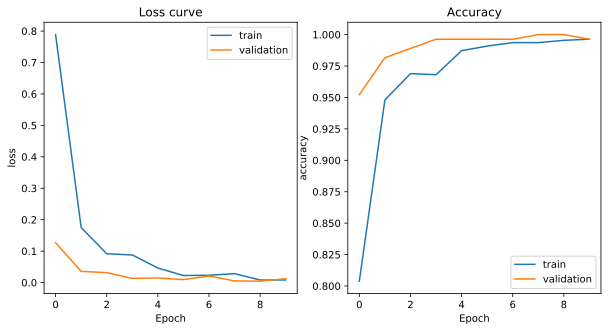

In [ ]:
# let's plot the loss and accuracy 

# get the training and validation accuracy from the history object
train_acc = history1.history['accuracy']
valid_acc = history1.history['val_accuracy']

# get the loss
train_loss = history1.history['loss']
valid_loss = history1.history['val_loss']

# get the number of entries
xvalues = np.arange(len(train_acc))

# visualize
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(xvalues, train_loss)
ax[0].plot(xvalues, valid_loss)
ax[0].set_title("Loss curve")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("loss")
ax[0].legend(['train', 'validation'])

ax[1].plot(xvalues, train_acc)
ax[1].plot(xvalues, valid_acc)
ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend(['train', 'validation'])

plt.show()

## Model Interpretability
The most important part. How do we explain the output of our model? For example, given an image, what does the network consider important when classifying the image? Can we get info about it? Can we make our model a little grey box? LOL!

Answering the above question is a bit difficult. Although there have been many advancements in explaining the activations/outputs of a neural network, for example, check this excellent [distill article](https://distill.pub/2018/building-blocks/), a lot more has to be done in this direction.

Here, we will explore two methods that are very simple to use and can give some good insights about model predictions. These are:

* **Visualizing the intermediate layers outputs**
* **[Class Activation Mapping](http://cnnlocalization.csail.mit.edu/)**


We will start by selecting all the layers up to last convolution block in VGG16, excluding the Input layer. Define a new model, `vis_model`, that takes the same input as our model's input but outputs activations of all the intermediate layers we have selected. This will be used for displaying all the activation maps of each convolution block for any sample image from our validation data. 
Check `visualize_intermediate_activations()` function for more details.


For `CAM`, we will take the same sample image and get the output of the last convolution layer. We also compute the gradients for this layer which we will use to generate a heatmap. See the `get_CAM()` function for details.

In [ ]:
# select all the layers for which you want to visualize the outputs and store it in a list
outputs = [layer.output for layer in model.layers[1:18]]

# Define a new model that generates the above output
vis_model = Model(model.input, outputs)

# store the layer names we are interested in
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])

    
print("Layers going to be used for visualization: ")
print(layer_names)

Layers going to be used for visualization: 
['block1_conv1_1', 'block1_conv2_1', 'block1_pool_1', 'block2_conv1_1', 'block2_conv2_1', 'block2_pool_1', 'block3_conv1_1', 'block3_conv2_1', 'block3_conv3_1', 'block3_pool_1', 'block4_conv1_1', 'block4_conv2_1', 'block4_conv3_1', 'block4_pool_1', 'block5_conv1_1', 'block5_conv2_1', 'block5_conv3_1']


In [ ]:
def get_CAM(processed_image, predicted_label, layer_name='block5_conv3'):
    """
    This function is used to generate a heatmap for a sample image prediction.
    
    Args:
        processed_image: any sample image that has been pre-processed using the 
                       `preprocess_input()`method of a keras model
        predicted_label: label predicted by the network for this image
    
    Returns:
        heatmap: heatmap generated over the last convolution layer output 
    """
    
    # this will be the model that would give us the graidents
    model_grad = Model([model.inputs], 
                       [model.get_layer(layer_name).output, model.output])
    
    # Gradient tape gives you everything you need
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)
        loss = predictions[:, predicted_label]
    
    # get the gradients wrt to the chosen layer
    grads_values = tape.gradient(loss, conv_output_values)
    
    # take mean gradient per feature map
    grads_values = K.mean(grads_values, axis=(0,1,2))
    
    # convert to numpy. This is done just for image operations.
    # Check for shapes and you would understand why we performed 
    # the squeeze operation here.
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()
    
    
    # iterate over each feature map in yout conv output and multiply
    # the gradient values with the conv output values. This gives an 
    # indication of "how important a feature is"
    for i in range(512): # we have 512 features in our last conv layer
        conv_output_values[:,:,i] *= grads_values[i]
    
    # create a heatmap
    heatmap = np.mean(conv_output_values, axis=-1)
    
    # remove negative values
    heatmap = np.maximum(heatmap, 0)
    
    # normalize
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [ ]:
def show_random_sample(idx):
    """
    This function is used to select a random sample from the validation dataframe.
    It generates prediction for the same. It also stores the heatmap and the intermediate
    layers activation maps.
    
    Arguments:
        idx: random index to select a sample from validation data
    
    Returns:
        activations: activation values for intermediate layers
    """
    # select the sample and read the corresponding image and label
    sample_image = cv2.imread(valid_df.iloc[idx]['image'])
    sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
    sample_image = cv2.resize(sample_image, (img_rows, img_cols))
    sample_label = valid_df.iloc[idx]["label"]
    
    # pre-process the image
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    sample_image_processed = preprocessing_fn(sample_image_processed)
    
    # generate activation maps from the intermediate layers using the visualization model
    activations = vis_model.predict(sample_image_processed)
    
    # get the label predicted by our original model
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    # choose any random activation map from the activation maps 
    sample_activation = activations[0][0,:,:,16]
    
    # normalize the sample activation map
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    # convert pixel values between 0-255
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    
    
    # get the heatmap for class activation map(CAM)
    heatmap = get_CAM(sample_image_processed, pred_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    super_imposed_image = heatmap * 0.5 + sample_image
    super_imposed_image = np.clip(super_imposed_image, 0,255).astype(np.uint8)

    f,ax = plt.subplots(2,2, figsize=(15,8))
    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.show()
    
    return activations

Let's visualize **CAM** for some examples now

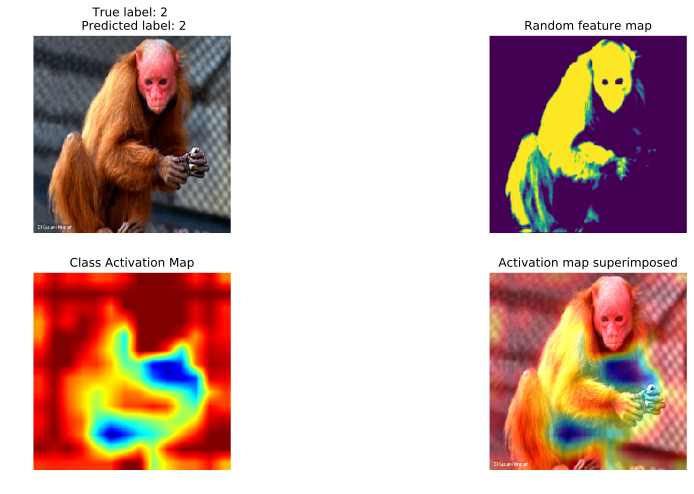

In [ ]:
_ = show_random_sample(idx=123)

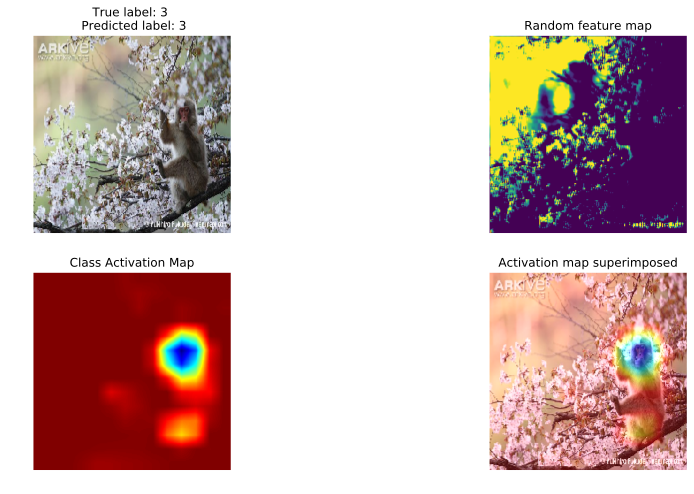

In [ ]:
_ = show_random_sample(idx=100)

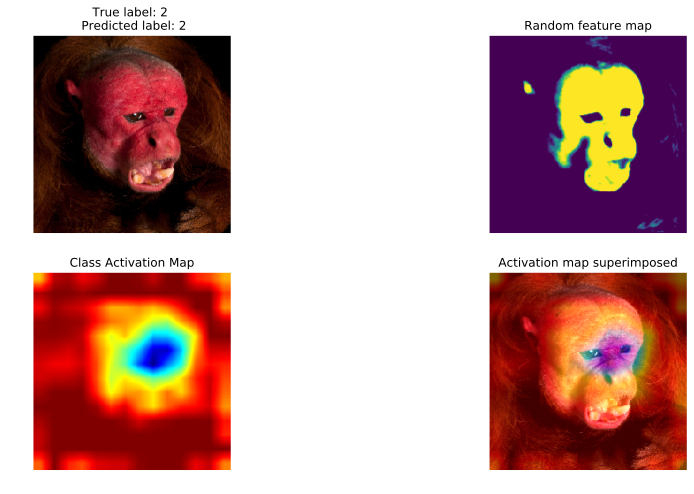

In [ ]:
activations = show_random_sample(idx=15)

### Intermediate layers output visualization

We will take the activations generated for the last sample and check the output
of intermediate layers for visualization

In [ ]:
def visualize_intermediate_activations(layer_names, activations):
    """
    This function is used to visualize all the itermediate activation maps
    
    Arguments:
        layer_names: list of names of all the intermediate layers we chose
        activations: all the intermediate activation maps 
    """
    assert len(layer_names)==len(activations), "Make sure layers and activation values match"
    images_per_row=16
    
    for layer_name, layer_activation in zip(layer_names, activations):
        nb_features = layer_activation.shape[-1]
        size= layer_activation.shape[1]

        nb_cols = nb_features // images_per_row
        grid = np.zeros((size*nb_cols, size*images_per_row))

        for col in range(nb_cols):
            for row in range(images_per_row):
                feature_map = layer_activation[0,:,:,col*images_per_row + row]
                feature_map -= feature_map.mean()
                feature_map /= feature_map.std()
                feature_map *=255
                feature_map = np.clip(feature_map, 0, 255).astype(np.uint8)

                grid[col*size:(col+1)*size, row*size:(row+1)*size] = feature_map

        scale = 1./size
        plt.figure(figsize=(scale*grid.shape[1], scale*grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(grid, aspect='auto', cmap='viridis')
    plt.show()

In [ ]:
visualize_intermediate_activations(activations=activations, 
                                   layer_names=layer_names)

This cell output is too large and can only be displayed while logged in.
